# CS541: Applied Machine Learning, Spring 2025, Lab 10
Lab 10 is an exercise that explores Explainable Artificial Intelligence(XAI). This is a collection of procedures and techniques that enable machine learning algorithms to produce output and results that are understandable and reliable for human users. Today in lab we will be exploring popular techniques such as GradCAM which allows us to visual where a network looked at to make it's decision. Additionally we will be looking at LIME a method that gives regional justifications for predictions provided by sophisticated machine learning models.


GradCAM - a popular method to visualize where a network looked at for it's decisions

**Lab Grading**

Labs are hands-on exercises designed to provide guided experience in key concepts through this class.  You are graded based on in-lab participation (not correctness), and **are required to submit** your lab work after class, before Friday of that week.  *Make sure you fill out the attendence form before leaving class*.

For students who miss a lab, you can submit a make-up lab on gradescope by the Friday directly following the lab for partial credit.  Please see the syllabus for the lab grading policy.

In [2]:
import torch
from torch.nn import functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import urllib
import json

In [3]:
model = models.resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
def process_image(image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image).unsqueeze(0)
    return image

# Download the ImageNet class index file
# Loads a dictionary mapping ImageNet class indices to human-readable labels.
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
imagenet_classes = json.loads(urllib.request.urlopen(url).read().decode("utf-8"))

# Converts a class ID to a readable name, like "tabby_cat".
def get_class_name(class_id):
    return imagenet_classes[str(class_id)][1]


## Load an image

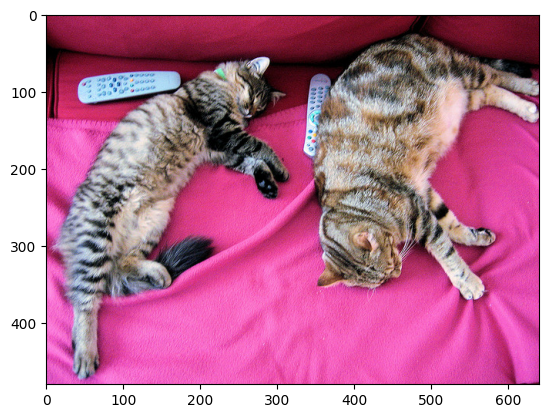

In [5]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# url = "https://farm3.staticflickr.com/2321/4510729803_9272ef7e5b_z.jpg"
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPU_rl3SBaQ9ZCbpAgoCn2Z-bbbkd16OjEKw&s"

image = Image.open(requests.get(url, stream=True).raw)
input_image = process_image(image)

plt.imshow(image)

### There are many classes in the image: Cats, remotes, bedsheet.... Which one do you think will the model predict?

**Your answer:**  Cat

## Let's make GradCAM: visualizing the activations of the hidden layers

In [6]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.feature_map = None
        self.grads = None

        self.register_hooks()

    # Hooks allow access to intermediate forward outputs and backward gradients of specific layers.
    def register_hooks(self):
        def forward_hook(module, input, output):
            # Set the feature map to the output
            self.feature_map = output

        def backward_hook(module, grad_in, grad_out):
            # Set the gradients to the first item in the grad_out
            self.grads = grad_out[0]

        layer = dict([*self.model.named_modules()])[self.layer_name]
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)

    def generate_heatmap(self):
        grads_val = self.grads.cpu().data.numpy().squeeze()
        fmap = self.feature_map.cpu().data.numpy().squeeze()
        weights = np.mean(grads_val, axis=(1, 2))

        cam = np.zeros(fmap.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            # For the cam variable we add its value to the weight multipled by the feature map that is on the cpu at the i'th position
            cam += w * fmap[i]

        # Get the element wise maximum value for cam by getting the maximum between cam and 0
        cam = np.maximum(cam, 0)
        # Set cam to be the difference between cam and the minimum value of cam
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        # Set cam to be the division between cam and the maximum value of cam
        # cam =
        return cam

gradcam = GradCAM(model, 'layer4')

In [7]:
# Forward pass
output = model(input_image)
class_id = output.argmax(dim=1).item()

# Backward pass for the selected class
model.zero_grad()
class_output = output[0, class_id]
class_output.backward()

# Generate heatmap
heatmap = gradcam.generate_heatmap()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


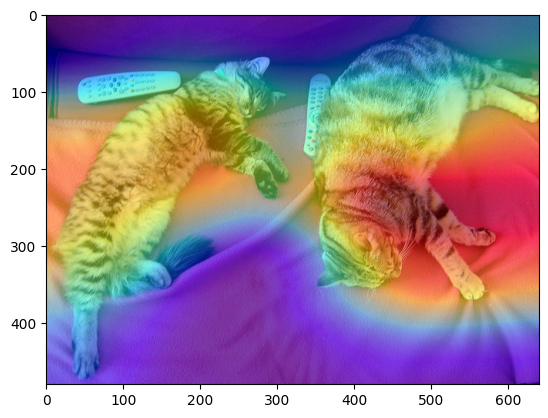

In [8]:
def show_heatmap_on_image(heatmap, img):
    heatmap = Image.fromarray(np.uint8(255 * heatmap))
    # heatmap = heatmap.resize(img.size, Image.ANTIALIAS)
    heatmap = heatmap.resize(img.size, Image.Resampling.LANCZOS)
    heatmap = np.array(heatmap)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.show()

show_heatmap_on_image(heatmap, image)

### Which one do you think the model predicted?



In [9]:
print("Predicted class: ", get_class_name(class_id))

Predicted class:  tabby


## Let's play a game: Can you tell what class a model would predict by looking at the heatmap?

In [10]:
example_images = [
    "https://farm3.staticflickr.com/2252/2219447936_56218fddf6_z.jpg",
    "https://farm3.staticflickr.com/2321/4510729803_9272ef7e5b_z.jpg",
    "https://farm1.staticflickr.com/140/406518020_a591010f07_z.jpg",
    "https://farm9.staticflickr.com/8392/8678231575_d289af321d_z.jpg",
    "https://farm6.staticflickr.com/5330/8758936099_3ef6837f4a_z.jpg",
    "https://farm2.staticflickr.com/1083/1262574286_108adc0882_z.jpg",
    "https://farm1.staticflickr.com/46/143306993_ee87f4ab60_z.jpg",
    "https://farm4.staticflickr.com/3292/5699595203_a4efab0681_z.jpg",
    "https://farm3.staticflickr.com/2161/2482567631_1beb0b226e_z.jpg"
]

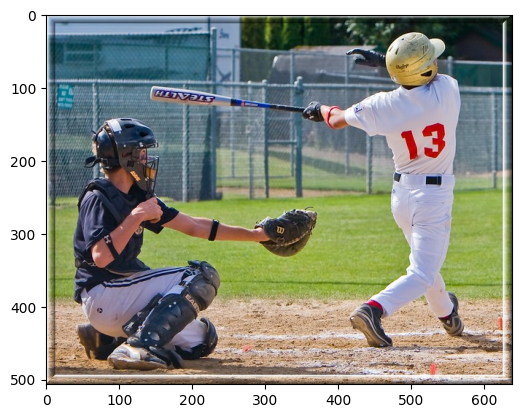

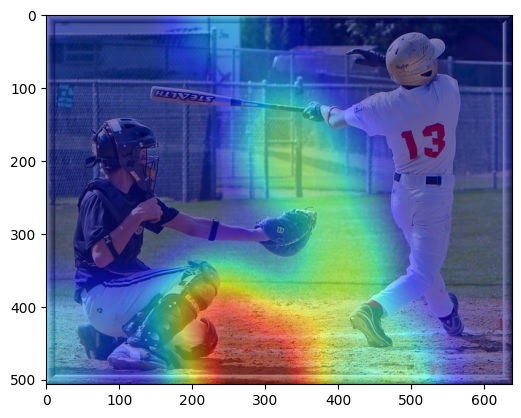

Enter the class name: dirt
You entered dirt
Model predicted class :  ballplayer
----------------------------------


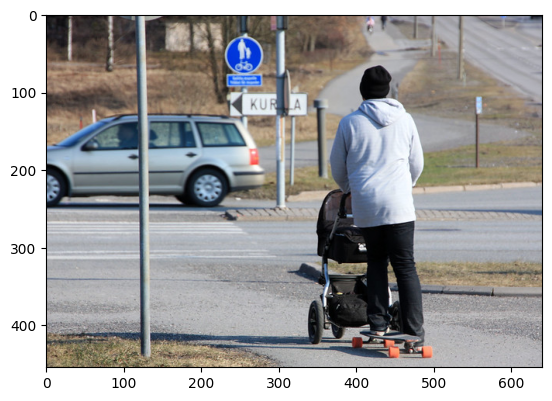

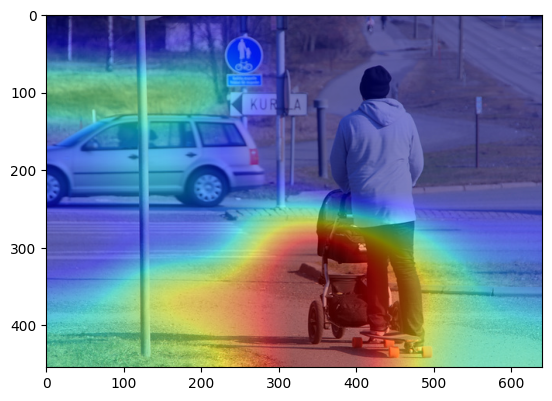

Enter the class name: skateboard
You entered skateboard
Model predicted class :  tricycle
----------------------------------


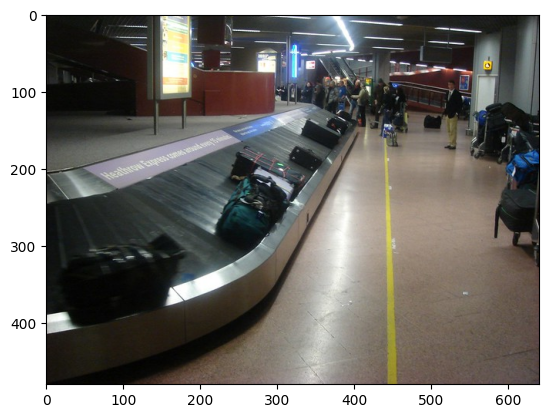

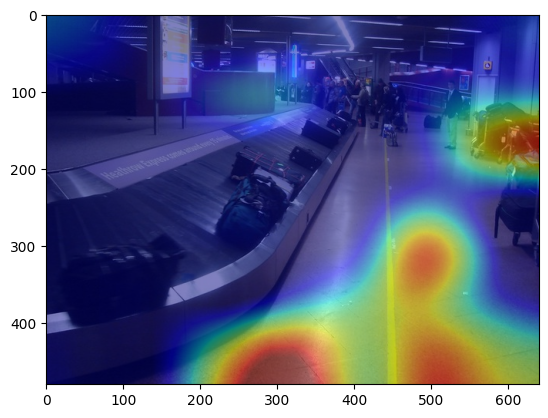

Enter the class name: floor
You entered floor
Model predicted class :  limousine
----------------------------------


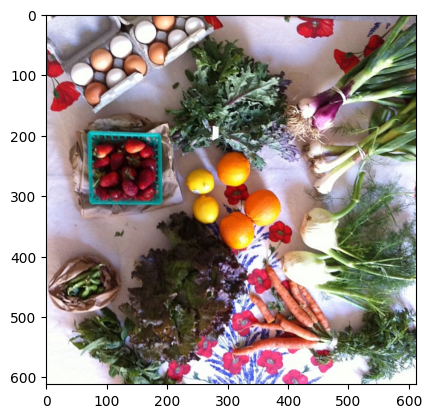

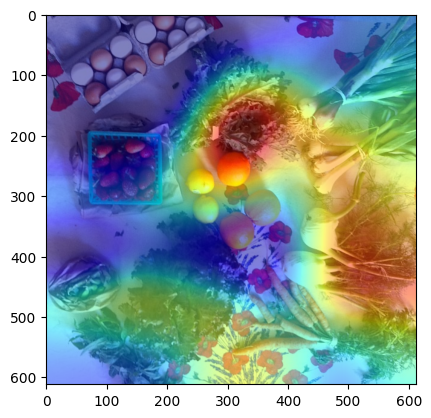

Enter the class name: greens
You entered greens
Model predicted class :  plate
----------------------------------


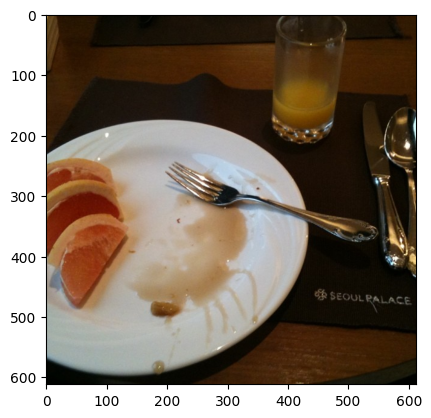

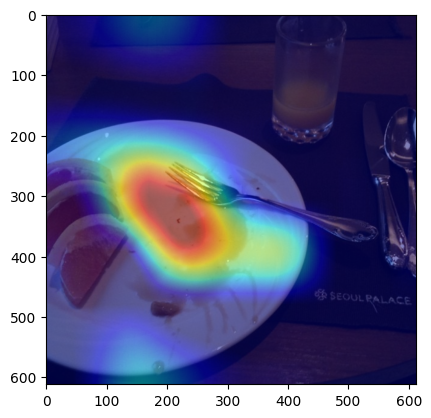

Enter the class name: plate
You entered plate
Model predicted class :  plate
----------------------------------


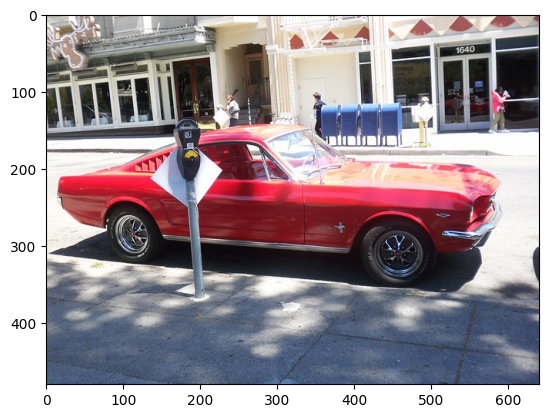

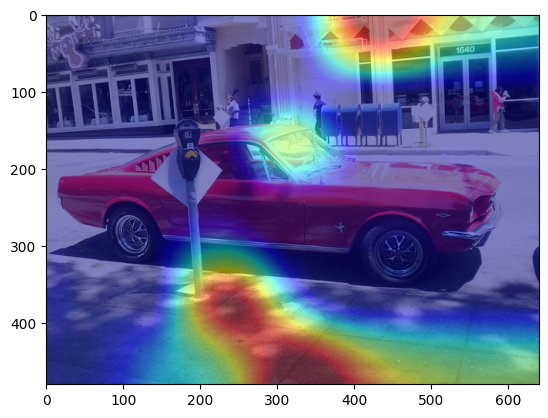

Enter the class name: car
You entered car
Model predicted class :  sports_car
----------------------------------


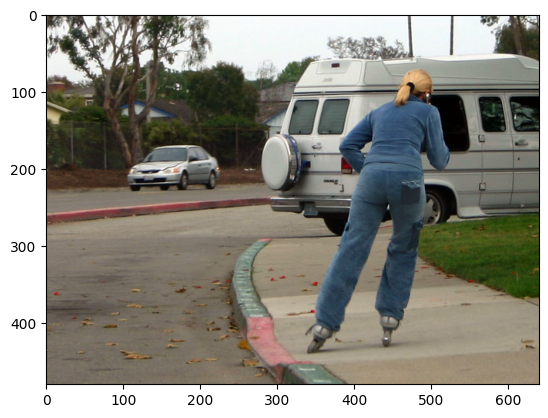

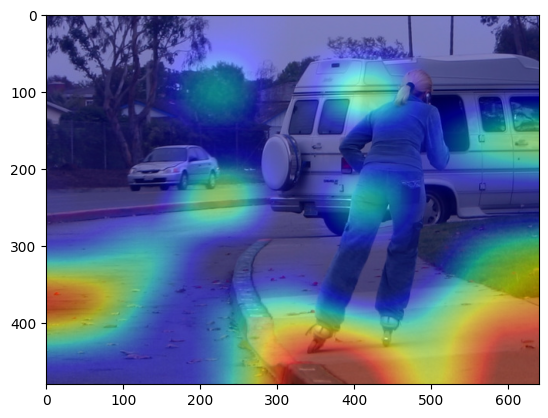

Enter the class name: roller skates
You entered roller skates
Model predicted class :  recreational_vehicle
----------------------------------


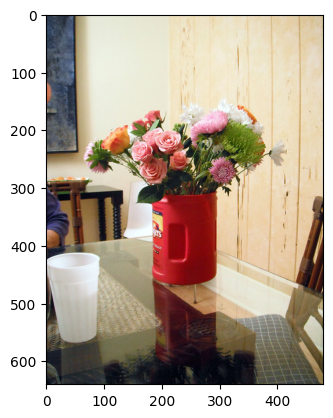

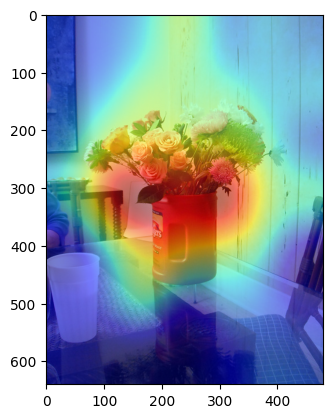

Enter the class name: flowers
You entered flowers
Model predicted class :  pot
----------------------------------


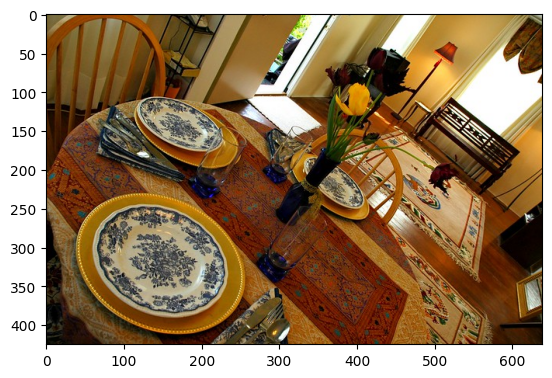

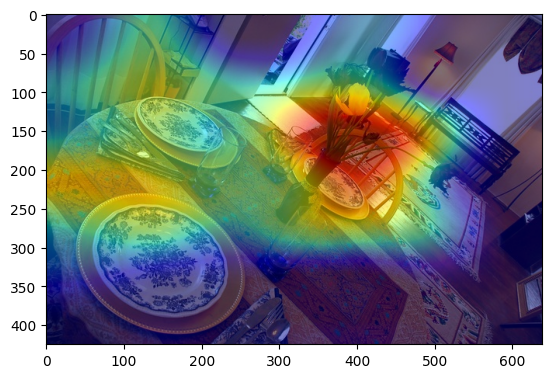

Enter the class name: plates
You entered plates
Model predicted class :  magnetic_compass
----------------------------------


In [11]:

for image_path in example_images:

  # do NOT print out the class name here.
  url = image_path
  # url = "https://farm3.staticflickr.com/2321/4510729803_9272ef7e5b_z.jpg"
  image = Image.open(requests.get(url, stream=True).raw)
  input_image = process_image(image)

  plt.imshow(image)
  plt.show()
  # Forward pass
  output = model(input_image)
  class_id = output.argmax(dim=1).item()


  # Backward pass for the selected class
  model.zero_grad()
  class_output = output[0, class_id]
  class_output.backward


  # Generate heatmap using the method we define in GradCam
  heatmap = gradcam.generate_heatmap()

  show_heatmap_on_image(heatmap, image)

 # your guess of the model predicted class
  class_name = input('Enter the class name: ')
  print(f'You entered {class_name}')

  print("Model predicted class : ", get_class_name(class_id))

  print("----------------------------------")


In [12]:
# your prediction of what the model predicted
your_predictions = ['dirt', 'skateboard', 'floor', 'greens', 'plate', 'car', 'roller skates', 'flowers', 'plates']

### Were your predictions close to what you thought the model would predict after seeing the heatmap?

Your answer: In general yes, but not all of them.

# Does the output change by much if we use ResNet 101?

# Here we go about using LIME to determine how why our model picks the classifications it assigns for given inputs

In [13]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d019fe07df50c98f5879343d3693957e47cf26657eaf7259f6b4849afea34900
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.segmentation import mark_boundaries

import torch
import torchaudio
import torchaudio.transforms as atransforms
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as vtransforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

# Set the GPU if available otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'PyTorch version= {torch.__version__}')
print(f'torchaudio version= {torchaudio.__version__}')
print(f'torchvision version= {torchvision.__version__}')
print(f'CUDA available= {torch.cuda.is_available()}')

if torch.cuda.is_available():
    # CUDA Installation
    print('CUDA Version')
    !nvcc --version
    print()

    # CUDNN Installation
    print(f'CUDNN Version: {torch.backends.cudnn.version()}')
    print(f'Number of CUDA Devices: {torch.cuda.device_count()}')
    print(f'Active CUDA Device: {torch.cuda.current_device()}')
    print(f'Available devices: {torch.cuda.device_count()}, Name: {torch.cuda.get_device_name(0)}')
    print(f'Current CUDA device: {torch.cuda.current_device()}')

PyTorch version= 2.6.0+cu124
torchaudio version= 2.6.0+cu124
torchvision version= 0.21.0+cu124
CUDA available= True
CUDA Version
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0

CUDNN Version: 90300
Number of CUDA Devices: 1
Active CUDA Device: 0
Available devices: 1, Name: Tesla T4
Current CUDA device: 0


In [15]:
# Get the training and testing datasets from a path with resize and normalization
def get_dataloader(_img_size, _bs, _ds, _path):
    train_ds = _ds(
        root=_path, download=True, train=True,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    # Use pin_memory=True to fix GPU memory
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=_bs, shuffle=True,
                                           # pin_memory=True,
                                           num_workers=4)

    test_ds = _ds(
        root=_path, download=True, train=False,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=_bs, shuffle=True,
                                          # pin_memory=True,
                                          num_workers=4)

    return train_dl, test_dl

def get_dl_mnist(_img_size, _bs):
    return get_dataloader(_img_size, _bs, dset.MNIST, './MNIST')

In [16]:
IMG_SIZE = 28
IMG_CHANNEL= 1  # color channel
MLP_HIDDEN= 16  # Hidden layer size
LAST_LINEAR_SIZE = 1024
N_CLASSES = 10  # output layer size
BATCH_SIZE = 5000

class ImageClassifierCNN(torch.nn.Module):
    def __init__(
            self,
            epochs=10,
            eta=0.001,
            batch_size=1000,
            seed=0
        ) -> None:
        super(ImageClassifierCNN, self).__init__()
        self.random = np.random.RandomState(seed)  # shuffle mini batches
        self.epochs = epochs  # number of iterations
        self.eta = eta  # learning rate
        self.batch_size = batch_size
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.model = None

    def init_layers(self, _K):
        import torch.nn as nn
        self.model = nn.Sequential(
            # Use a 2D Convolution layer with an input channel of 1, a output channel of 16 and a kernel size of 5
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            # Create a relu layer with the inplace parameter set to True
            nn.ReLU(inplace=True),
            # Create a 2D max-pool layer with a kernel size of 2
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(MLP_HIDDEN),
            nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN*2, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Flatten(start_dim=1),
            nn.Linear(MLP_HIDDEN*2 * 4*4, LAST_LINEAR_SIZE),
            nn.BatchNorm1d(LAST_LINEAR_SIZE),
            # Create a linear layer with input of size 1024 and an output of the number of classes in our MNIST dataset
            nn.Linear(LAST_LINEAR_SIZE, out_features=10),
        ).to(device)

    def predict(self, input):
        if input.shape[-1] == 3:
            input = np.mean(input, axis=-1, keepdims=True)

        input = np.transpose(input, (0, 3, 1, 2))

        input = torch.FloatTensor(input).to(device, non_blocking=True)
        assert self.model is not None
        with torch.no_grad():
            logits = self.model(input)
        probabilities = F.softmax(logits, dim=1)
        return probabilities.cpu().numpy()

    def fit(self, _train_dl, info=False):
        import sys
        self.init_layers(N_CLASSES)

        optimizer = torch.optim.Rprop(self.model.parameters(), lr=self.eta)

        for e in range(self.epochs):
            for data in _train_dl:
                X, y = data[0].to(device), data[1].to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                net_out = self.model(X)
                loss = self.loss_func(net_out, y)
                loss.backward()
                optimizer.step()

            if info:
                with torch.no_grad():
                    acc = accuracy_score(data[1].tolist(), np.argmax(self.model(X).cpu(), axis=1).tolist())
                sys.stderr.write(f"\r{e+1:02d}/{self.epochs:02d} | Loss: {loss:<6.2f} | Tr Acc: {acc*100:3.2f}%")
                sys.stderr.flush()

In [17]:
cnn = ImageClassifierCNN(batch_size=BATCH_SIZE).to(device)
cnn.init_layers(N_CLASSES)
print(cnn)

ImageClassifierCNN(
  (loss_func): CrossEntropyLoss()
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [18]:
%%time

# Get the datasets
train_dl, test_dl = get_dl_mnist(IMG_SIZE, BATCH_SIZE)

cnn.fit(train_dl, info=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
01/10 | Loss: 0.09   | Tr Acc: 97.94%/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

CPU times: user 4.79 s, sys: 2.3 s, total: 7.09 s
Wall time: 2min 12s


In [19]:
# Ensure the model is in evaluation mode
cnn.eval()

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Function to preprocess input image for the model
def preprocess(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    return transform(image).unsqueeze(0)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

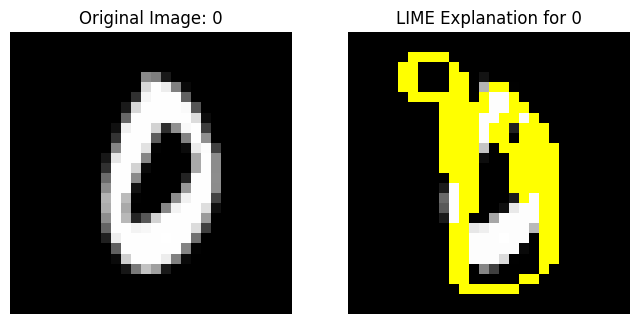

  0%|          | 0/1000 [00:00<?, ?it/s]

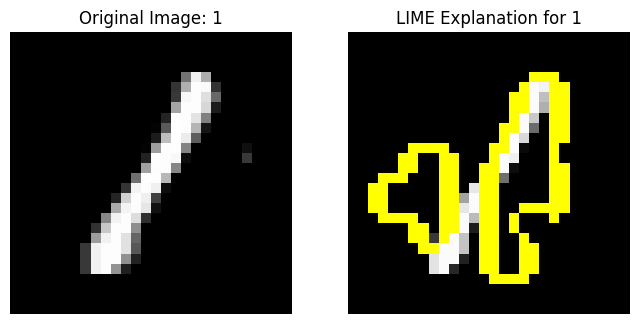

  0%|          | 0/1000 [00:00<?, ?it/s]

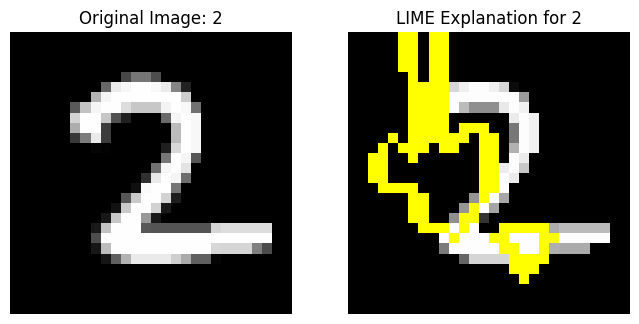

  0%|          | 0/1000 [00:00<?, ?it/s]

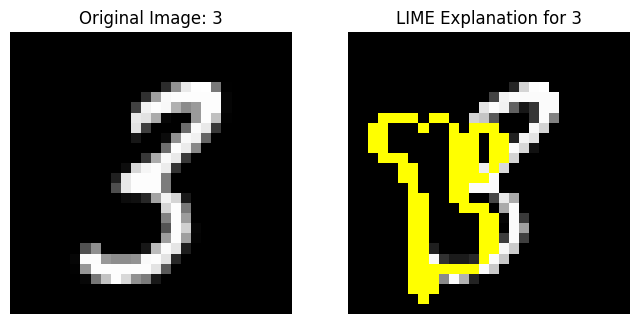

  0%|          | 0/1000 [00:00<?, ?it/s]

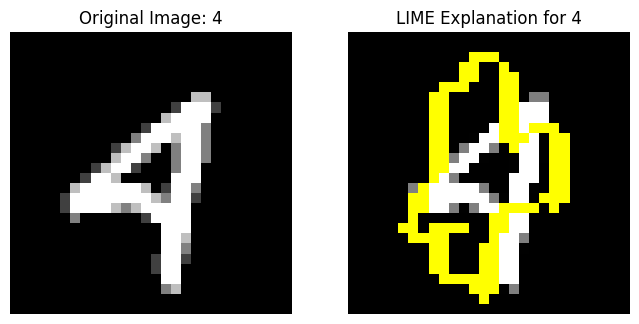

  0%|          | 0/1000 [00:00<?, ?it/s]

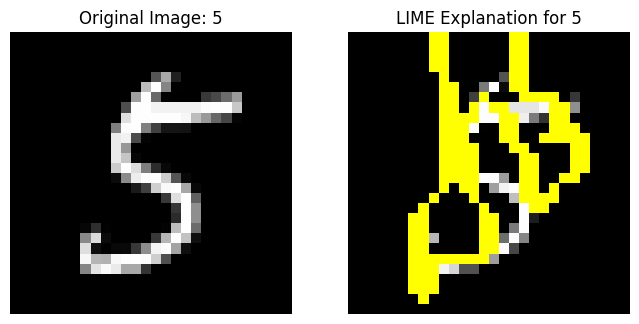

  0%|          | 0/1000 [00:00<?, ?it/s]

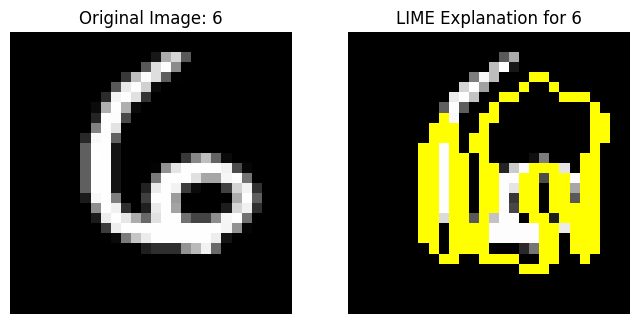

  0%|          | 0/1000 [00:00<?, ?it/s]

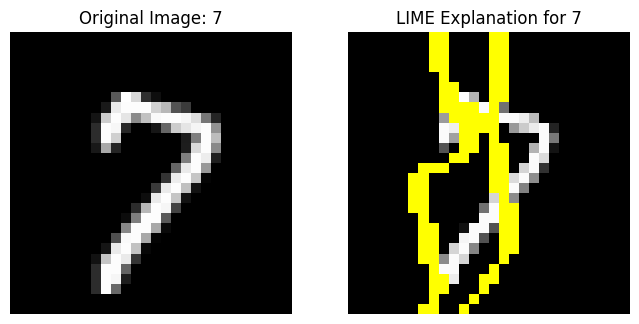

  0%|          | 0/1000 [00:00<?, ?it/s]

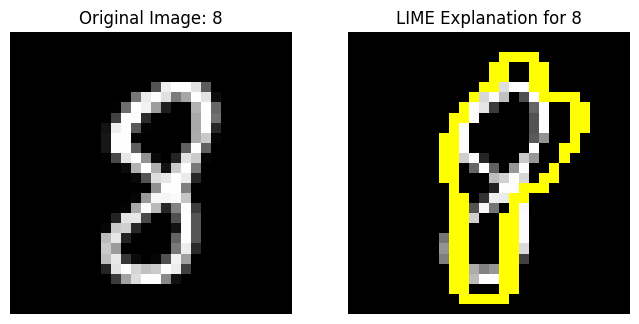

  0%|          | 0/1000 [00:00<?, ?it/s]

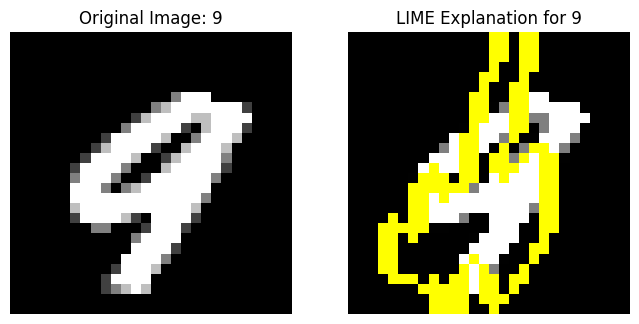

In [20]:
# Initialize a dictionary to store one image for each digit
digit_examples = {}

# Iterate over the test data loader to collect one example for each digit
for images, labels in test_dl:
    labels_list = labels.tolist()
    for i, label in enumerate(labels_list):
        if label not in digit_examples:
            # Detach the image tensor and convert to numpy array
            digit_examples[label] = images[i].detach().numpy()

        # If we've collected all digits, break out of loop
        if len(digit_examples) == 10:
            break

    # If we've collected all digits, break out of loop
    if len(digit_examples) == 10:
        break

# Create a SegmentationAlgorithm object with 'slic' algorithm
# Configures the SLIC segmentation algorithm, which divides an image into 100 coherent regions (“superpixels”) for LIME to perturb.

segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

# Now iterate through each digit and explain using LIME
for digit in range(10):
    # Retrieve the selected image of the digit from the dictionary
    image = np.squeeze(digit_examples[digit])

    # Get explanation from LIME
    explanation = explainer.explain_instance(image,
                                             cnn.predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000,
                                             segmentation_fn=segmentation_fn)

    # Get image and mask for the explanation of the digit
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=5,
                                                hide_rest=False)

    # Plot the image and the explanation
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image: {digit}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for {digit}')
    plt.axis('off')

    plt.show()


The yellow portion of the images in the LIME output represent the "explanation" of what parts of the image were most influential in the model's decision to classify the digits.

Are there any specific patterns discriminating certain digits?

**Answer:** There does not seem to be specific patters, at least human interpretable.


In [21]:
# Get the training and testing datasets from a path with resize and normalization
def get_dataloader(_img_size, _bs, _ds, _path):
    train_ds = _ds(
        root=_path, download=True, train=True,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    # Use pin_memory=True to fix GPU memory
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=_bs, shuffle=True,
                                           # pin_memory=True,
                                           num_workers=4)

    test_ds = _ds(
        root=_path, download=True, train=False,
        transform=vtransforms.Compose([
            vtransforms.Resize(_img_size),
            vtransforms.ToTensor(),
            vtransforms.Normalize((0.5,), (0.5,))
        ]))

    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=_bs, shuffle=True,
                                          # pin_memory=True,
                                          num_workers=4)

    return train_dl, test_dl

def get_dl_fashion(_img_size, _bs):
    return get_dataloader(_img_size, _bs, dset.FashionMNIST, './FashionMNIST')

In [22]:
cnn = ImageClassifierCNN(batch_size=BATCH_SIZE).to(device)
cnn.init_layers(N_CLASSES)
print(cnn)

ImageClassifierCNN(
  (loss_func): CrossEntropyLoss()
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [23]:
%%time

# Get the datasets
train_dl, test_dl = get_dl_fashion(IMG_SIZE, BATCH_SIZE)

cnn.fit(train_dl, info=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
01/10 | Loss: 0.45   | Tr Acc: 84.68%/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

CPU times: user 4.5 s, sys: 2.08 s, total: 6.58 s
Wall time: 2min 2s


In [25]:
# Ensure the model is in evaluation mode
cnn.eval()

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Function to preprocess input image for the model
def preprocess(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
    return transform(image).unsqueeze(0)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

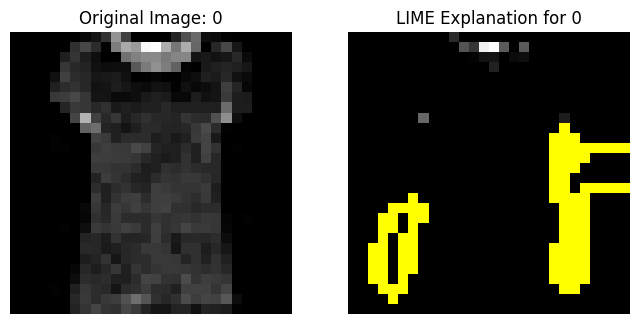

  0%|          | 0/1000 [00:00<?, ?it/s]

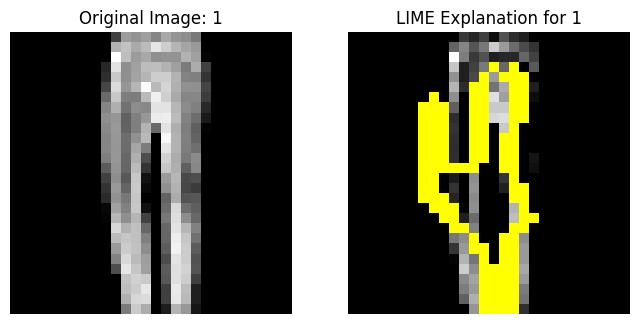

  0%|          | 0/1000 [00:00<?, ?it/s]

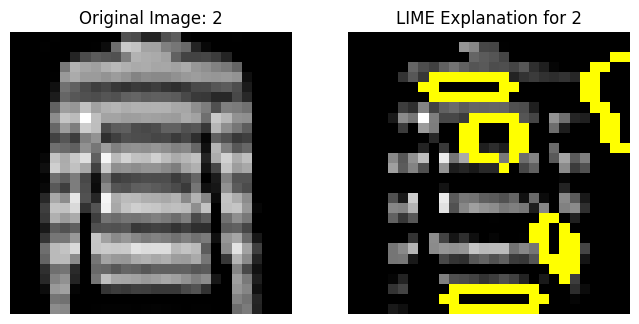

  0%|          | 0/1000 [00:00<?, ?it/s]

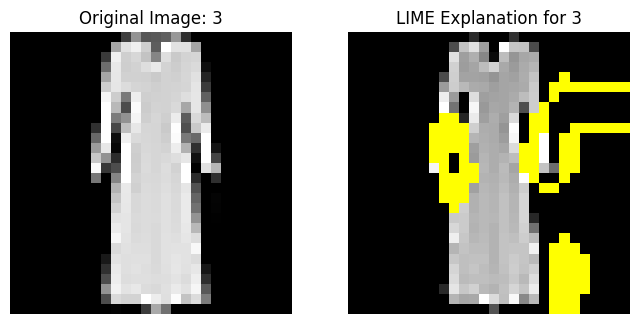

  0%|          | 0/1000 [00:00<?, ?it/s]

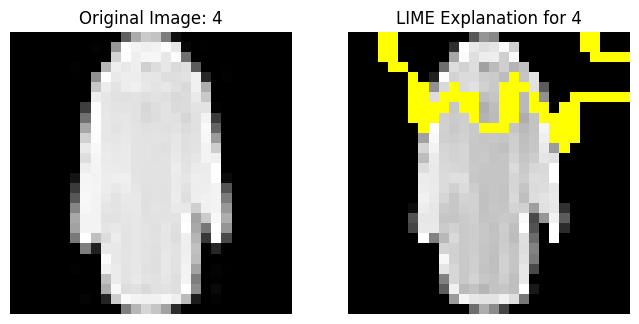

  0%|          | 0/1000 [00:00<?, ?it/s]

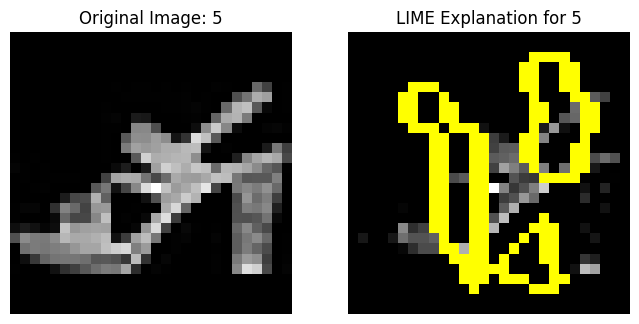

  0%|          | 0/1000 [00:00<?, ?it/s]

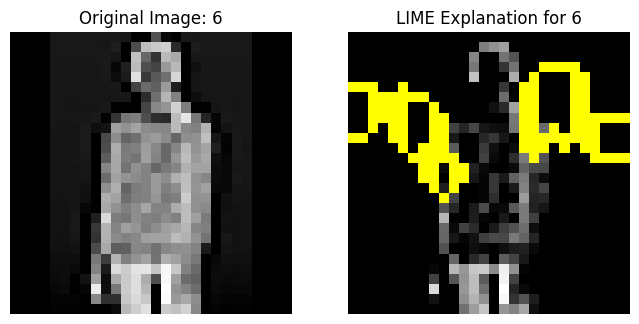

  0%|          | 0/1000 [00:00<?, ?it/s]

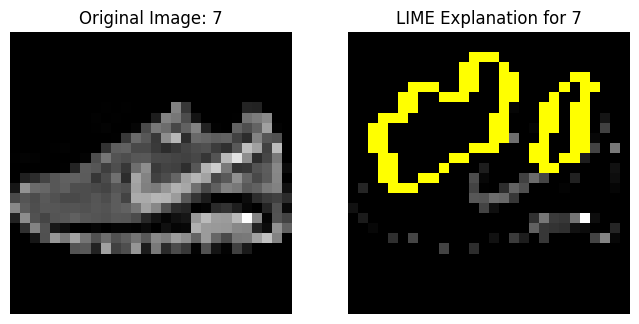

  0%|          | 0/1000 [00:00<?, ?it/s]

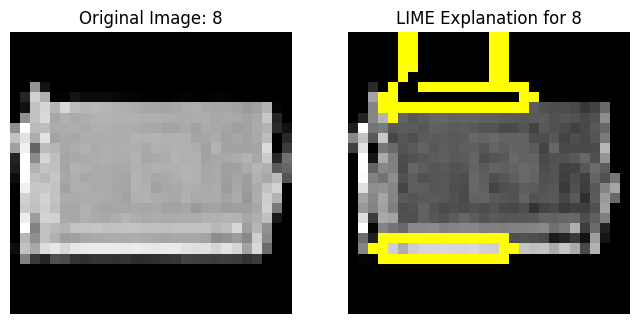

  0%|          | 0/1000 [00:00<?, ?it/s]

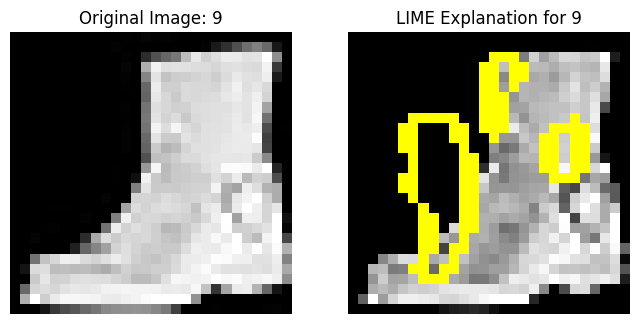

In [26]:
# Initialize a dictionary to store one image for each digit
digit_examples = {}

# Iterate over the test data loader to collect one example for each digit
for images, labels in test_dl:
    labels_list = labels.tolist()
    for i, label in enumerate(labels_list):
        if label not in digit_examples:
            # Detach the image tensor and convert to numpy array
            digit_examples[label] = images[i].detach().numpy()

        # If we've collected all digits, break out of loop
        if len(digit_examples) == 10:
            break

    # If we've collected all digits, break out of loop
    if len(digit_examples) == 10:
        break

# Create a SegmentationAlgorithm object with 'slic' algorithm
segmentation_fn = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

# Now iterate through each digit and explain using LIME
for digit in range(10):
    # Retrieve the selected image of the digit from the dictionary
    image = np.squeeze(digit_examples[digit])

    # Get explanation from LIME
    explanation = explainer.explain_instance(image,
                                             cnn.predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000,
                                             segmentation_fn=segmentation_fn)

    # Get image and mask for the explanation of the digit
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=True,
                                                num_features=5,
                                                hide_rest=False)

    # Plot the image and the explanation
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original Image: {digit}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for {digit}')
    plt.axis('off')

    plt.show()

# Can you improve the performance of the model for FashionMNIST? What if you trying changing some hyperparameters? Or you could add some more layers? See if you can improve the performance to 91%.

# Then we want to see if the LIME predictions change